<h1>PyTorch implementation of a U-Net model for a custom dataset</h1>

<h2>Dataset</h2>

<b>Dataset:- [Lungs CT DataSet]</b> https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data

<h2>Import required libraries </h2>

In [1]:
import json
import os
from pprint import pprint #
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

<h2>Dataset Preprocessing</h2>

In [3]:
root_dir = "C:/Users/amitc/Downloads/archive (3)/"

In [5]:
image_files = sorted(glob.glob(root_dir + '2d_images/' + '*.tif'))
mask_files = sorted(glob.glob(root_dir + '2d_masks/' + '*.tif'))

# Check that the number of images matches the number of masks
if len(image_files) == len(mask_files):
    print(f"Number of images files are {len(image_files)} & corresponding mask files are {len(mask_files)}")

Number of images files are 267 & corresponding mask files are 267


<h4>Split into train and test</h4>

In [7]:
#(60% training, 20% validation 20% testing)

# Split data into 80% training/validation and 20% testing
train_image_files, test_image_files, train_mask_files, test_mask_files = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Further Split the 80% training/validation set into 60% training and 20% validation
'''
To get 60% of the original dataset from the 80% training/validation set, we calculate the proportion:
Training Set Proportion: 60% / 80% = 0.60/0.80 = 0.75
Validation Set Proportion: 20% / 80% = 0.20/0.80 = 0.25

This means:
75% of the 80% training/validation set should go to the training set.
25% of the 80% training/validation set should go to the validation set.
'''

train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    train_image_files, train_mask_files, test_size=0.25, random_state=42
)


# Output the number of files in each set
print(f"Number of training image files: {len(train_image_files)} & Number of training mask files: {len(train_mask_files)}")
print(f"Number of validation image files: {len(val_image_files)} & Number of validation mask files: {len(val_mask_files)}")
print(f"Number of testing image files: {len(test_image_files)} &  Number of testing mask files:{len(test_mask_files)}")
print("\n")
print(f"Total Number of image files: {len(train_image_files)} + {len(val_image_files)}  + {len(test_image_files)} = {len(train_image_files) + len(val_image_files) + len(test_image_files) }")
print(f"Total Number of mask files: {len(train_mask_files)} + {len(val_mask_files)} + {len(test_mask_files)} = {len(train_mask_files) + len(val_mask_files) + len(test_mask_files) }")

Number of training image files: 159 & Number of training mask files: 159
Number of validation image files: 54 & Number of validation mask files: 54
Number of testing image files: 54 &  Number of testing mask files:54


Total Number of image files: 159 + 54  + 54 = 267
Total Number of mask files: 159 + 54 + 54 = 267


<h4>Segmentation Mask Preprocessing</h4>

In [9]:
from PIL import Image
import numpy as np

temp_image = Image.open(mask_files[0])

temp_image_array = np.array(temp_image)

print("Image shape:",temp_image_array.shape)

min_pixel_value = temp_image_array.min()
max_pixel_value = temp_image_array.max()

print(f"Pixel value range: {min_pixel_value} to {max_pixel_value}")

Image shape: (512, 512)
Pixel value range: 0 to 255


As we can see in above, the mask in form of [0,255] range which need to convert into [0,1] range.

<h4>The following function converts the mask in range of [0,255] range to [0,1].</h4>

In [11]:
def convert_to_0_and_1(mask_image):
    #mask_image = Image.open(path)  # Read mask file
    
    mask_image_array = np.array(mask_image)  # Convert to numpy array

    binary_mask_array = np.where(mask_image_array > 0, 1, 0)   # Syntax - np.where(condition, x, y)
    '''
    This function will check each pixel in the mask_array. 
    If the pixel value is greater than 0, it assigns a value of 1; otherwise, it assigns a value of 0. This effectively binarizes your mask.
    '''

    # binary_mask_array = np.expand_dims(binary_mask_array, axis=-1)
    return binary_mask_array

<h2>Custom Dataset Class</h2>

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [14]:
class CustomDataset(Dataset):
    def __init__(self, image_files, mask_files, transform = None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self,idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        try:
            # Load image and mask as grayscale
            image = Image.open(img_path).convert("L")  # 'L' mode for grayscale
            mask = Image.open(mask_path).convert("L")  # 'L' mode for grayscale

            mask = convert_to_0_and_1(mask)

            # Convert mask to a PIL Image and apply transformations
            mask = Image.fromarray(mask)  # Convert back to PIL Image

            if self.transform:
                try:
                    image = self.transform(image)
                    mask = self.transform(mask)
                except Exception as e:
                    print(f"Error in transformation: {e}")
                    raise
            
            # Adding a channel dimension to the mask and ensuring correct shape
            mask = mask.squeeze(0)  # Remove extra dimension if any
            mask = mask.unsqueeze(0).float()  # Add channel dimension and convert to float
        
            return image, mask

        except Exception as e:
            print(f"Failed to load data for index {idx}: {e}")
            raise

In [15]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.ToTensor(),
    ]
)

In [30]:
train_dataset = CustomDataset(image_files = train_image_files, mask_files = train_mask_files , transform = transform)

val_dataset = CustomDataset(image_files = val_image_files, mask_files = val_mask_files, transform = transform)

test_dataset = CustomDataset(image_files = test_image_files, mask_files = test_mask_files, transform = transform)

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)

val_dataloader = DataLoader(val_dataset, batch_size = 8, shuffle = False)

test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

<h2>UNet Model</h2>

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Contracting Path
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.enc5 = self.conv_block(512, 1024)

        # Expansion Path
        self.upconv5 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.dec4 = self.conv_block(1024, 512) 
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.dec1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Contracting Path
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        enc5 = self.enc5(F.max_pool2d(enc4, 2))
        
        # Expansive Path
        dec4 = self.upconv5(enc5)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv4(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv3(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv2(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        return torch.sigmoid(self.final_conv(dec1))

In [28]:
# Example usage
model = UNet()

<h2>Model Training</h2>

In [27]:
import torch.optim as optim
import torch.nn as nn
import torch

# Hyperparameters
learning_rate = 1e-4
num_epochs = 25

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Variable to keep track of the best loss
best_loss = float('inf')

model.train()

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    for batch_idx, (images, masks) in enumerate(train_dataloader):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{batch_idx + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')
    
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')
    
    # Save the model if the validation loss is the best so far
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './best_model.pth')
        print(f'Best model saved with loss {best_loss:.4f}')


Epoch [1/25], Step [10/20], Loss: 0.4402
Epoch [1/25], Step [20/20], Loss: 0.3227
Epoch [1/25], Validation Loss: 0.5906
Best model saved with loss 0.5906
Epoch [2/25], Step [10/20], Loss: 0.2818
Epoch [2/25], Step [20/20], Loss: 0.2681
Epoch [2/25], Validation Loss: 0.5127
Best model saved with loss 0.5127
Epoch [3/25], Step [10/20], Loss: 0.2442
Epoch [3/25], Step [20/20], Loss: 0.2241
Epoch [3/25], Validation Loss: 0.2435
Best model saved with loss 0.2435
Epoch [4/25], Step [10/20], Loss: 0.2345
Epoch [4/25], Step [20/20], Loss: 0.2247
Epoch [4/25], Validation Loss: 0.2235
Best model saved with loss 0.2235
Epoch [5/25], Step [10/20], Loss: 0.2056
Epoch [5/25], Step [20/20], Loss: 0.2194
Epoch [5/25], Validation Loss: 0.2159
Best model saved with loss 0.2159
Epoch [6/25], Step [10/20], Loss: 0.2008
Epoch [6/25], Step [20/20], Loss: 0.2142
Epoch [6/25], Validation Loss: 0.2141
Best model saved with loss 0.2141
Epoch [7/25], Step [10/20], Loss: 0.2013
Epoch [7/25], Step [20/20], Loss: 0

<h2>testing</h2>

In [77]:
import torch
from torch.utils.data import DataLoader
import torchmetrics
import matplotlib.pyplot as plt
import os

# Assuming the following are already defined:
# - UNet: The UNet model class
# - CustomDataset: Dataset class for loading CT images and masks
# - test_image_files: List of paths to test CT images
# - test_mask_files: List of paths to corresponding test masks
# - transform: Transformations to apply to the test images

# Instantiate the dataset and dataloader
test_dataset = CustomDataset(image_files=test_image_files, mask_files=test_mask_files, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Instantiate the model and load the trained weights
model = UNet()  # Replace with the actual model initialization
model.load_state_dict(torch.load('./best_model.pth'))  # Load model from ./best_model.pth
model.eval()

# Send the model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize Dice metric from torchmetrics
dice_metric = torchmetrics.Dice(multiclass=False, threshold=0.5).to(device)

# Create a directory to save the predictions if it does not exist
os.makedirs('predictions', exist_ok=True)

# Loop through the test dataloader
with torch.no_grad():  # No need to compute gradients during testing
    for i, (images, true_masks) in enumerate(test_dataloader):
        images = images.to(device)
        true_masks = true_masks.to(device)

        # Forward pass: Get predictions from the model
        predicted_masks = model(images)

        # Apply threshold to get binary masks (e.g., threshold = 0.5)
        predicted_masks = (predicted_masks > 0.5).long()  # Convert to integer (binary) masks

        # Convert true masks to integer type if necessary
        true_masks = true_masks.long()

        # Update Dice metric
        dice_metric.update(predicted_masks, true_masks)

        # Convert tensors to numpy arrays for visualization
        images_np = images.cpu().numpy().squeeze()
        true_masks_np = true_masks.cpu().numpy().squeeze()
        predicted_masks_np = predicted_masks.cpu().numpy().squeeze()

        # Calculate and print the Dice score for the current batch
        dice_score = dice_metric.compute().item()
        print(f'Sample {i + 1} Dice Score: {dice_score:.4f}')

        # Save the plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(images_np, cmap='gray')
        
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(true_masks_np, cmap='gray')
        
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(predicted_masks_np, cmap='gray')

        plt.suptitle(f'Sample {i + 1} Dice Score: {dice_score:.4f}', fontsize=16)

        # Save the plot
        plt.savefig(f'predictions/sample_{i}.png')
        plt.close()

# Calculate average Dice score
average_dice_score = dice_metric.compute().item()
print(f'Average Dice Score on Test Set: {average_dice_score:.4f}')


Sample 1 Dice Score: 0.9659
Sample 2 Dice Score: 0.9657
Sample 3 Dice Score: 0.9714
Sample 4 Dice Score: 0.9732
Sample 5 Dice Score: 0.9768
Sample 6 Dice Score: 0.9751
Sample 7 Dice Score: 0.9753
Sample 8 Dice Score: 0.9749
Sample 9 Dice Score: 0.9763
Sample 10 Dice Score: 0.9774
Sample 11 Dice Score: 0.9776
Sample 12 Dice Score: 0.9782
Sample 13 Dice Score: 0.9775
Sample 14 Dice Score: 0.9759
Sample 15 Dice Score: 0.9761
Sample 16 Dice Score: 0.9759
Sample 17 Dice Score: 0.9766
Sample 18 Dice Score: 0.9772
Sample 19 Dice Score: 0.9764
Sample 20 Dice Score: 0.9770
Sample 21 Dice Score: 0.9770
Sample 22 Dice Score: 0.9750
Sample 23 Dice Score: 0.9757
Sample 24 Dice Score: 0.9755
Sample 25 Dice Score: 0.9754
Sample 26 Dice Score: 0.9758
Sample 27 Dice Score: 0.9749
Sample 28 Dice Score: 0.9751
Sample 29 Dice Score: 0.9749
Sample 30 Dice Score: 0.9749
Sample 31 Dice Score: 0.9744
Sample 32 Dice Score: 0.9747
Sample 33 Dice Score: 0.9746
Sample 34 Dice Score: 0.9748
Sample 35 Dice Score: 0

<h3> Display predicted Results </h3>

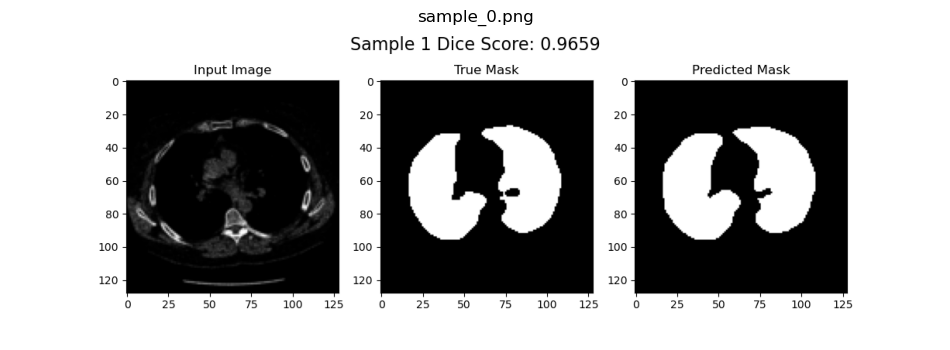

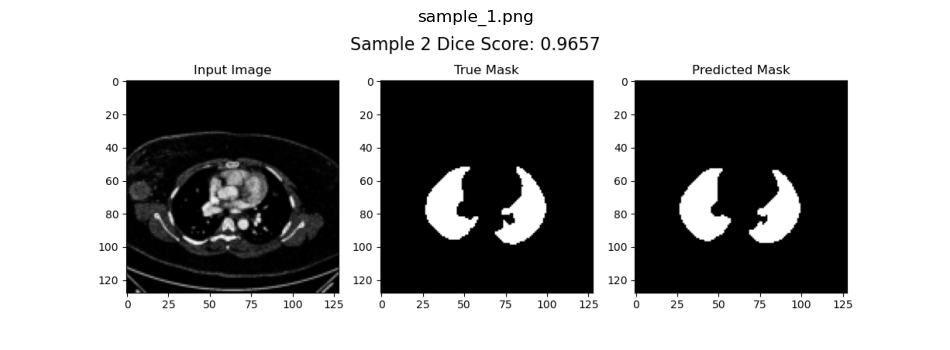

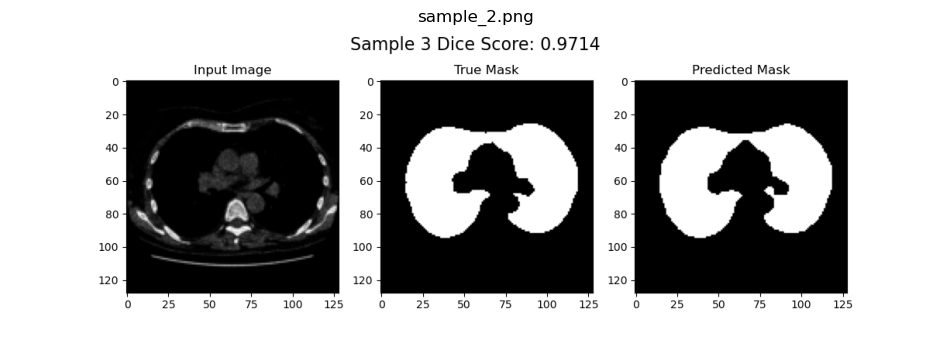

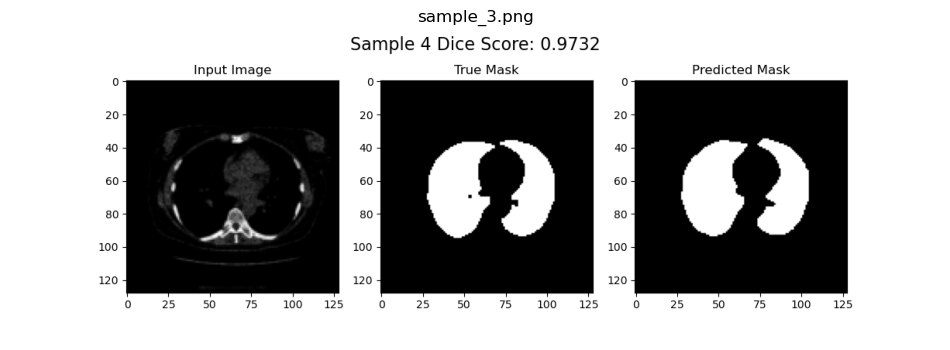

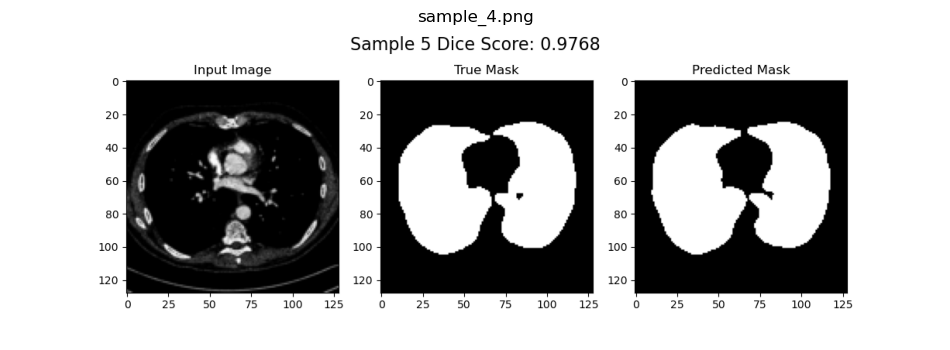

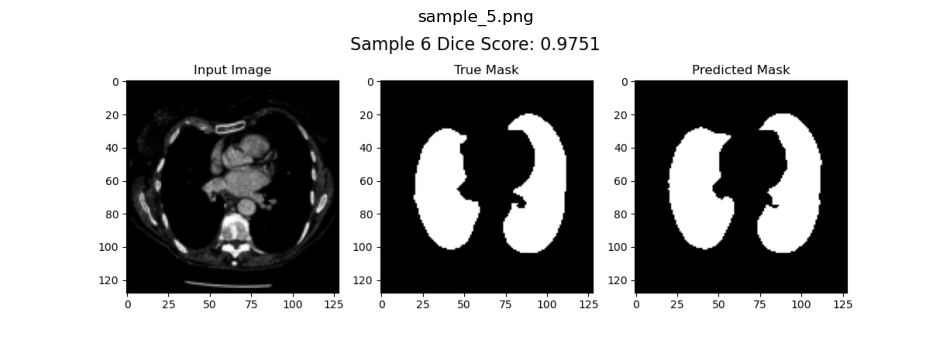

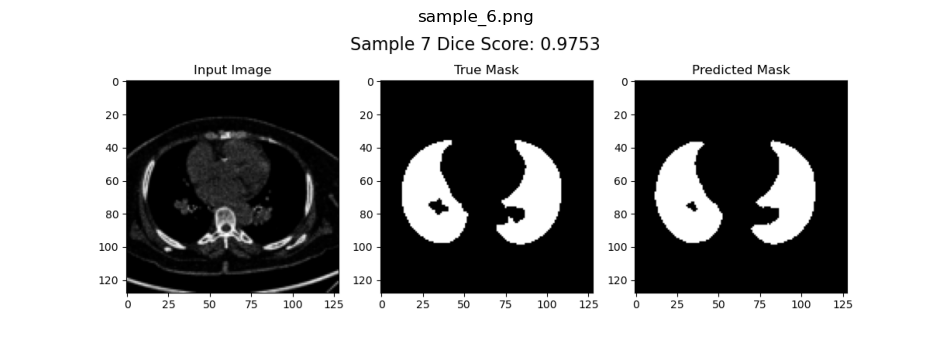

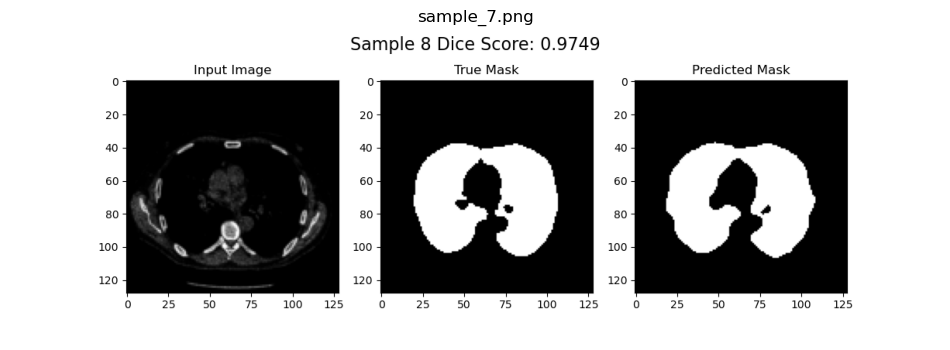

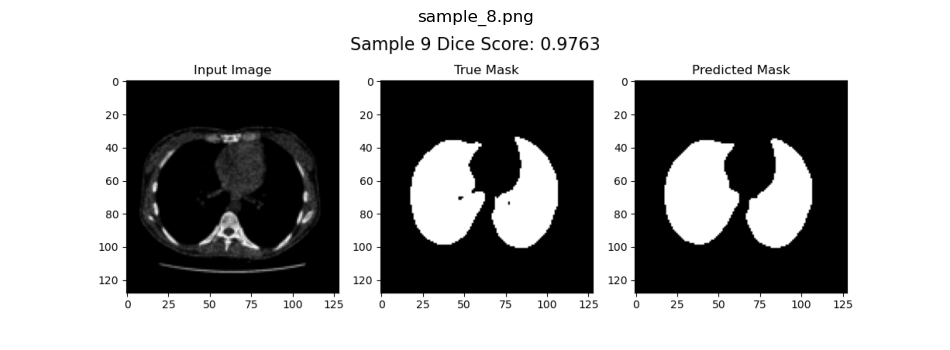

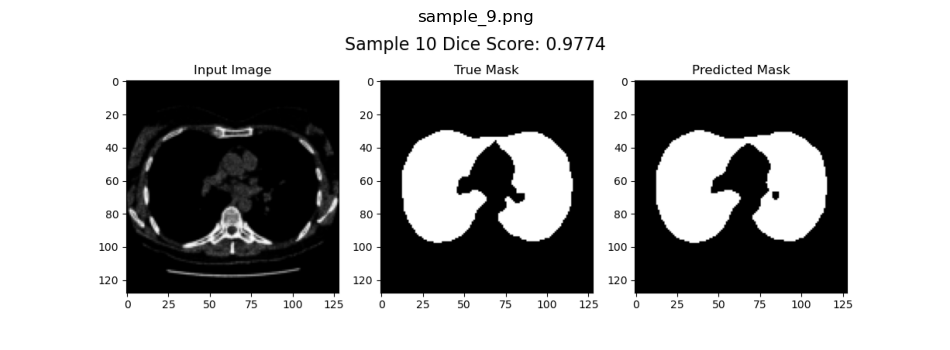

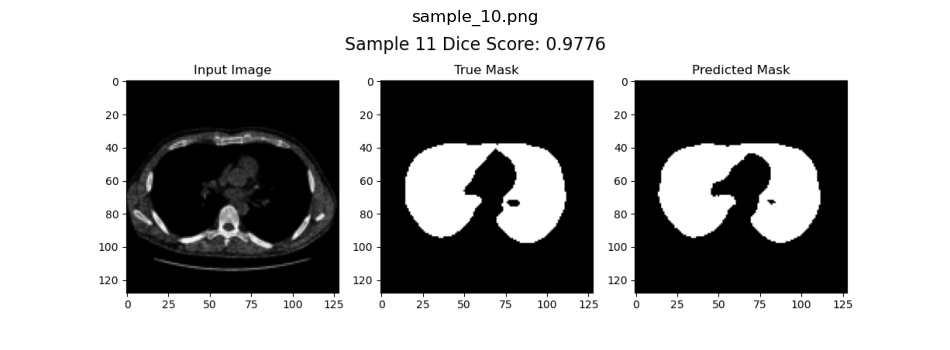

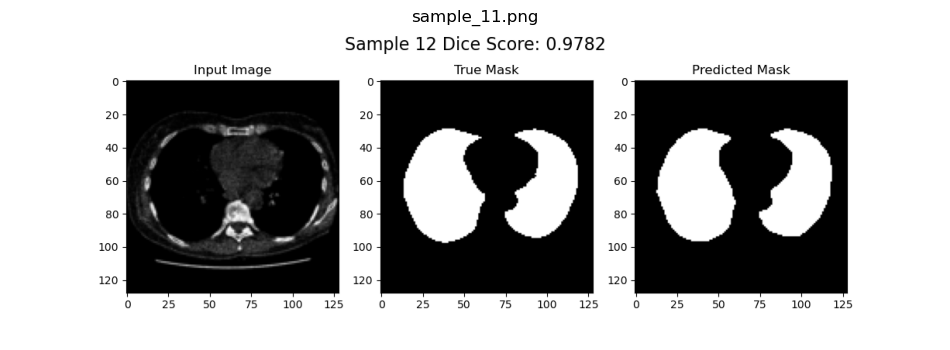

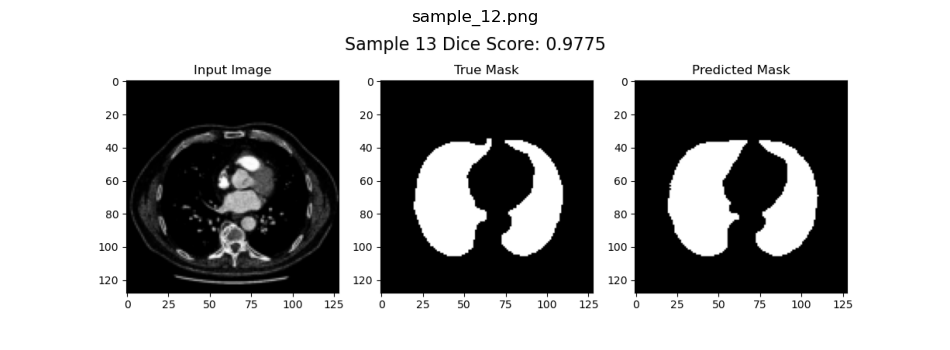

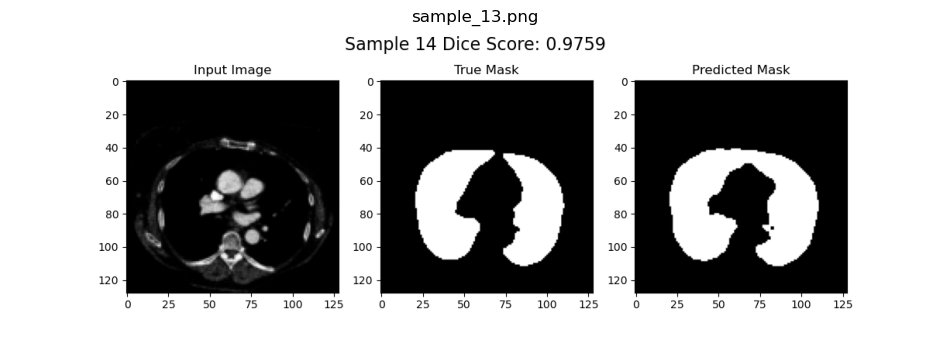

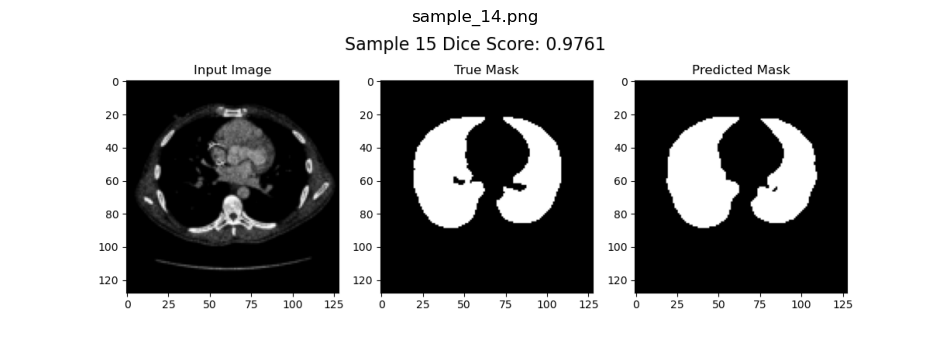

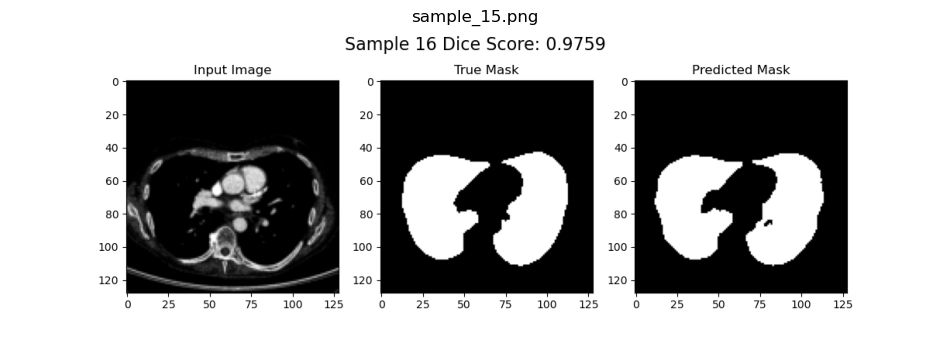

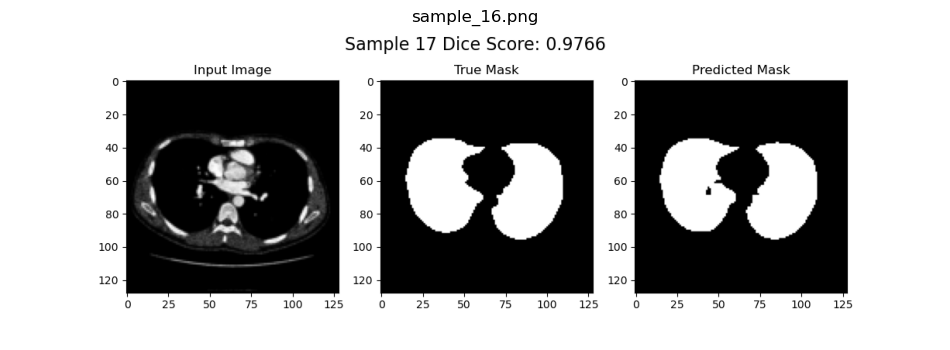

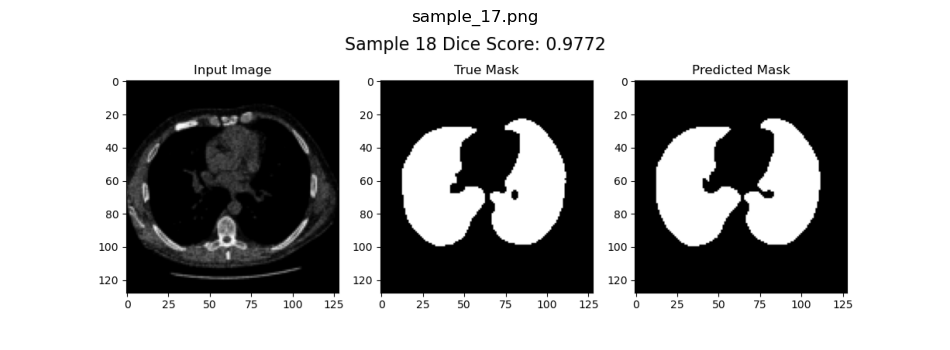

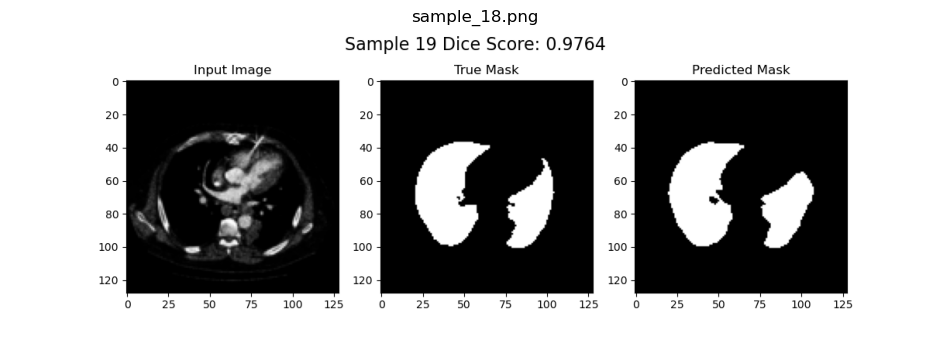

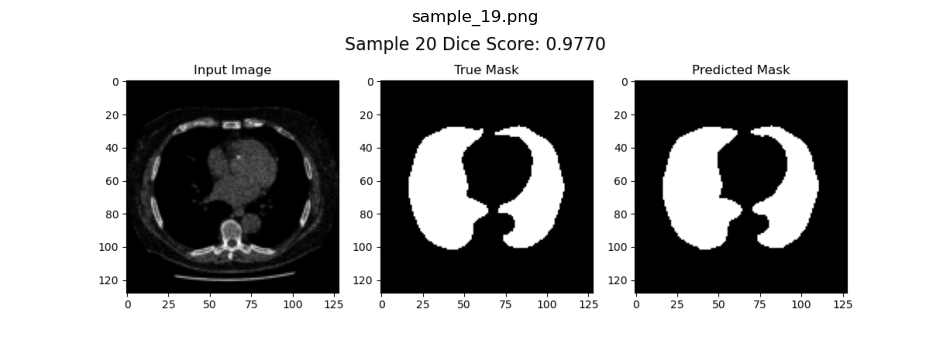

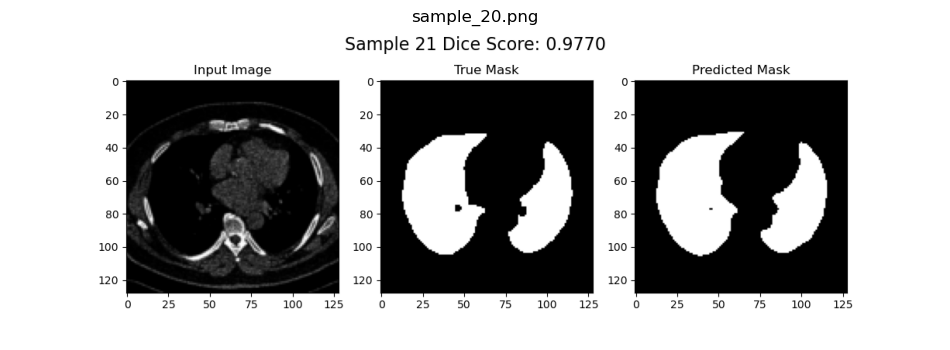

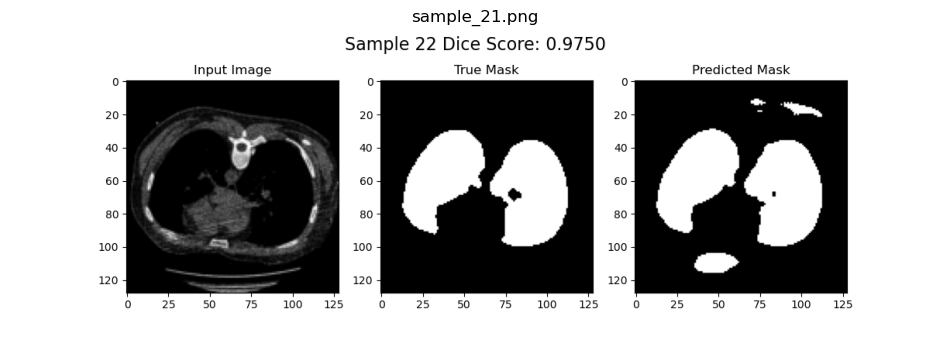

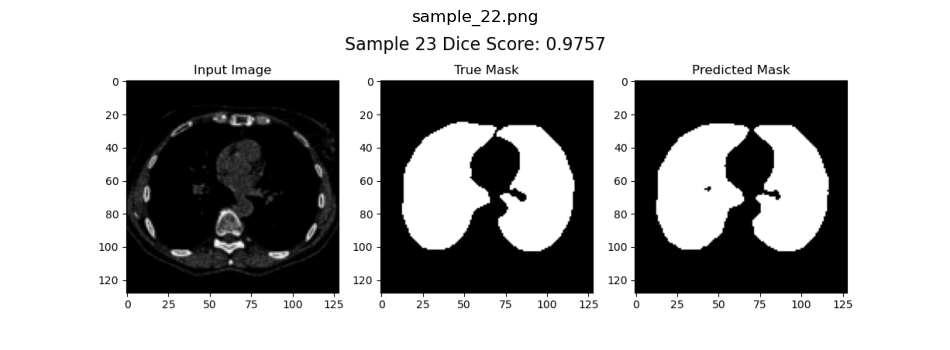

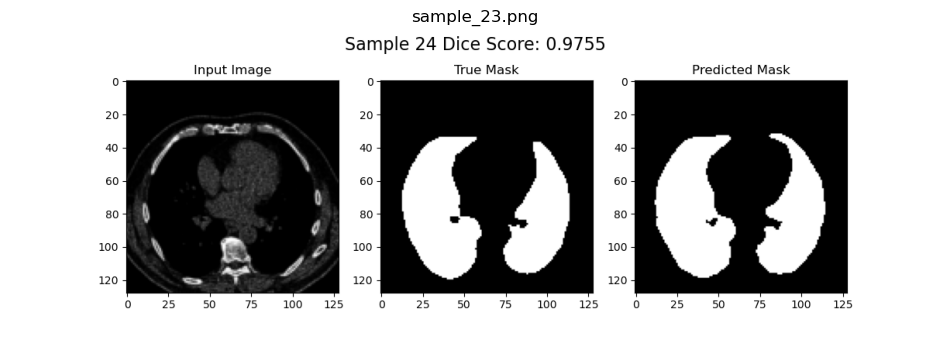

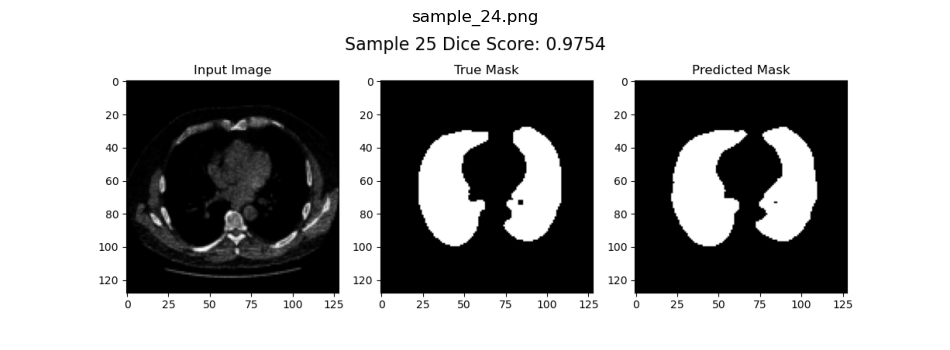

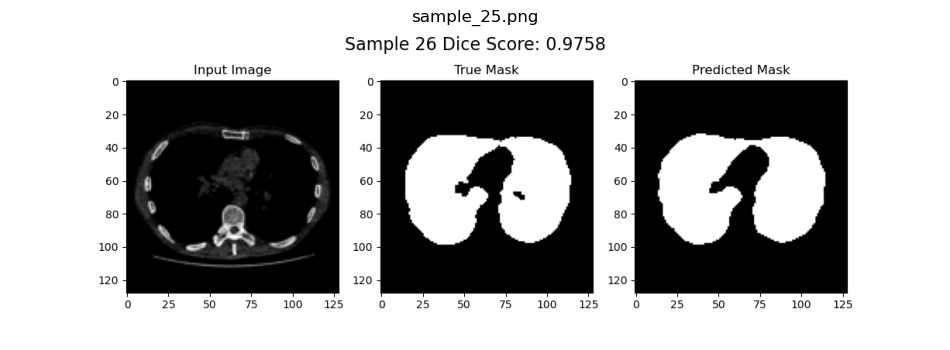

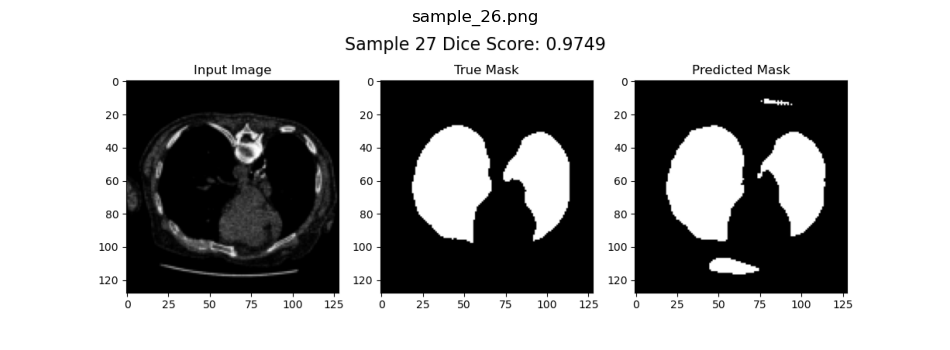

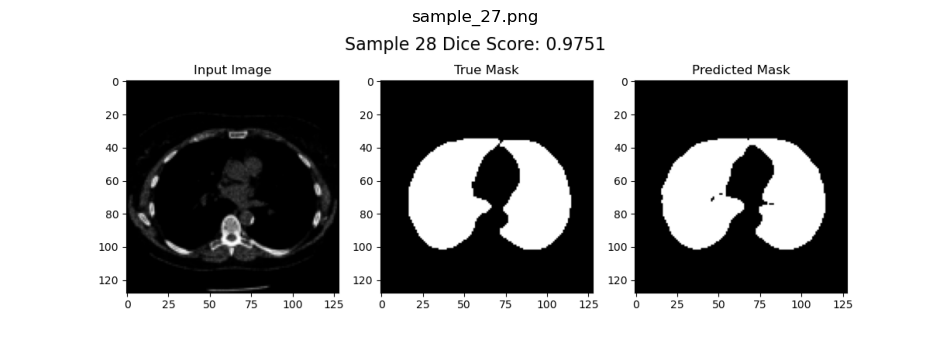

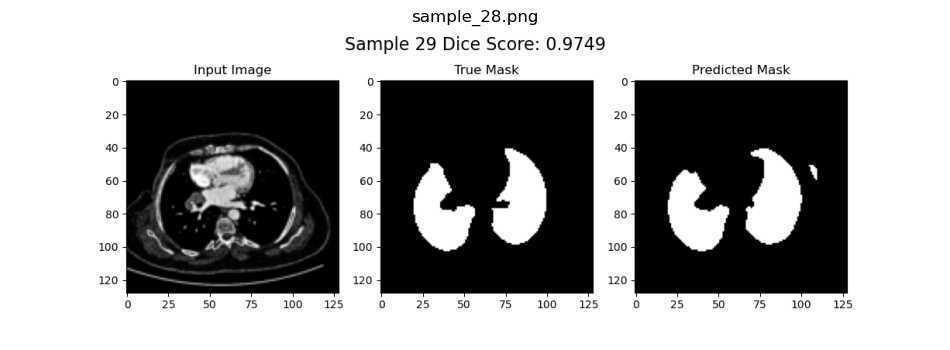

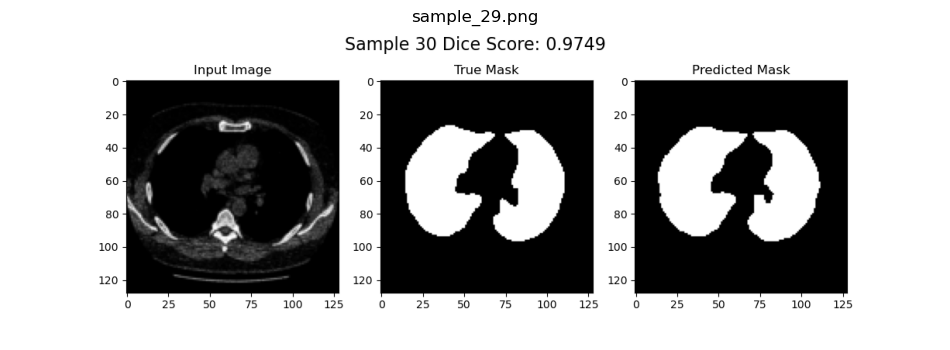

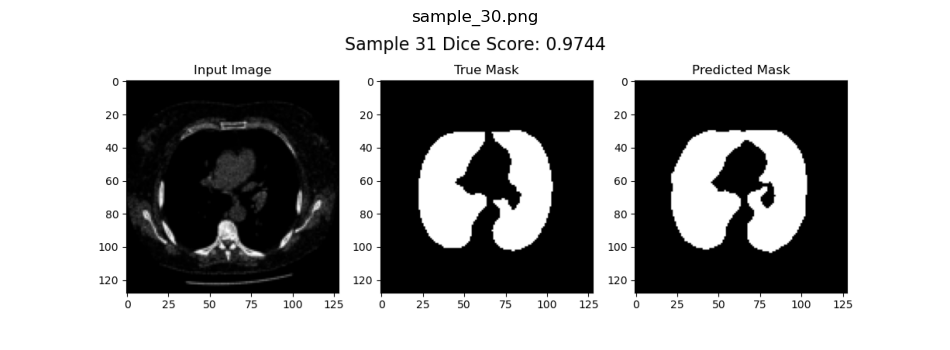

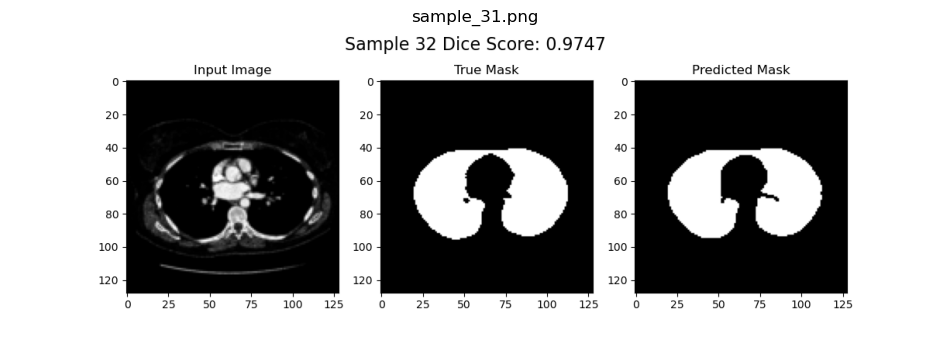

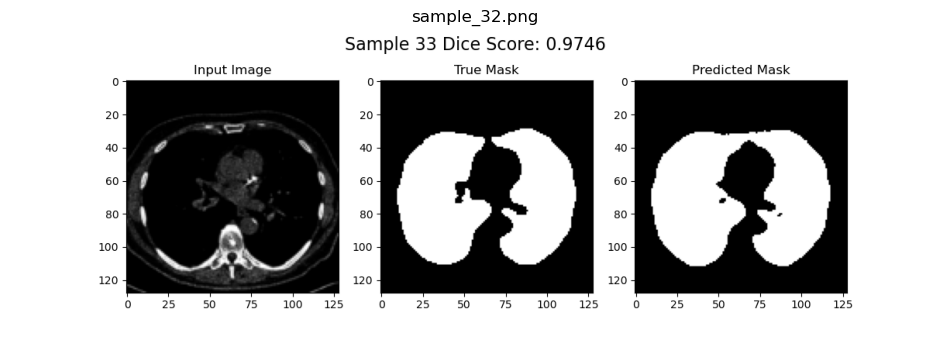

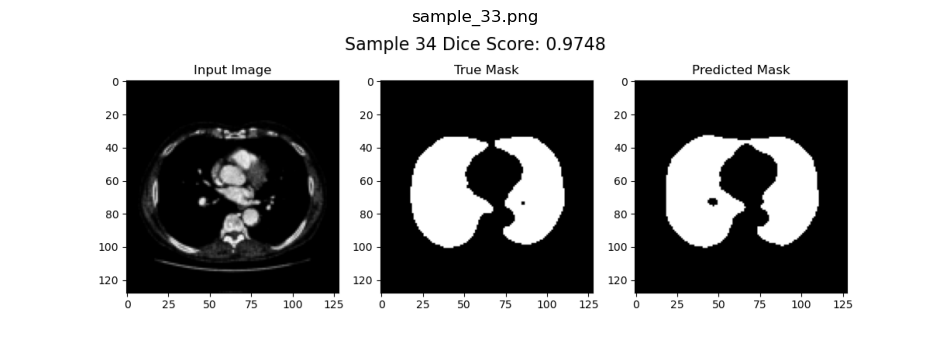

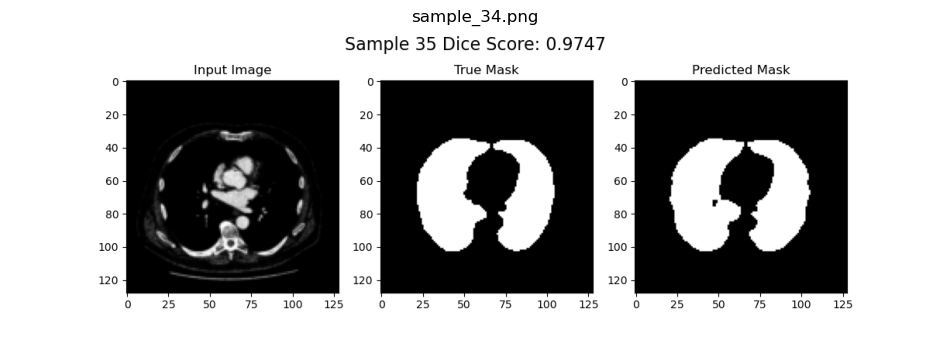

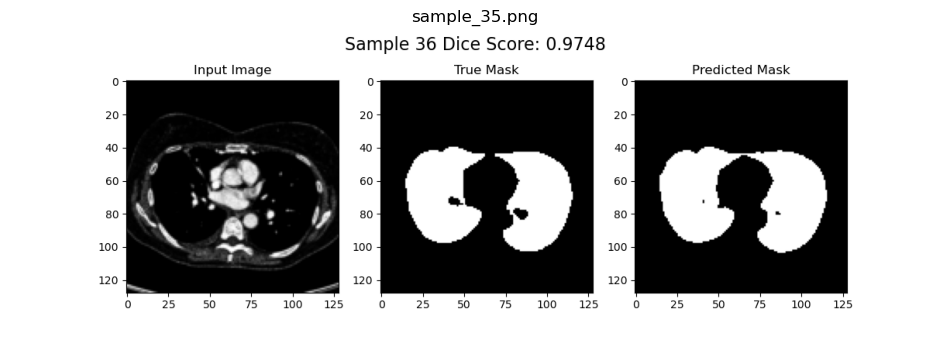

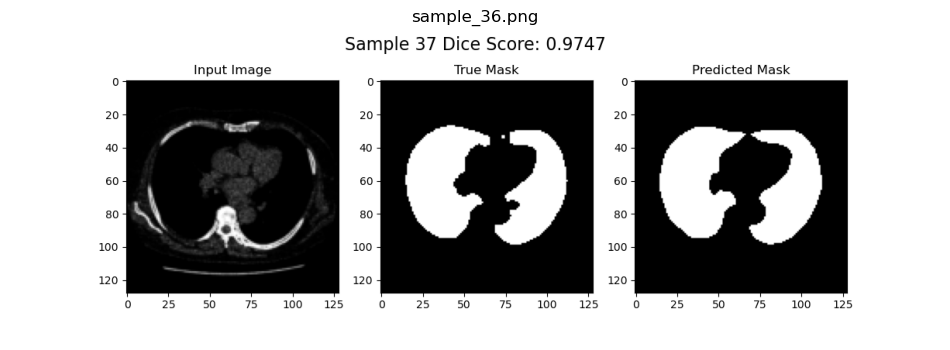

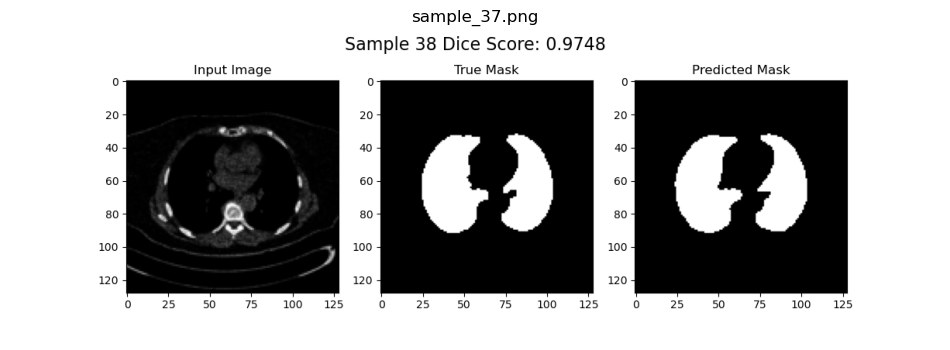

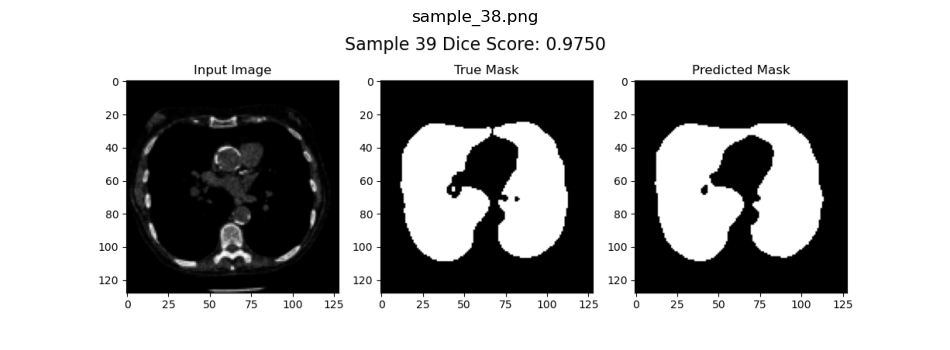

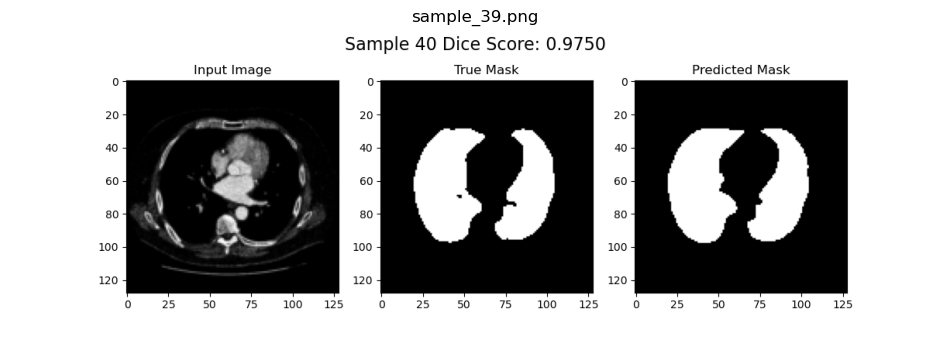

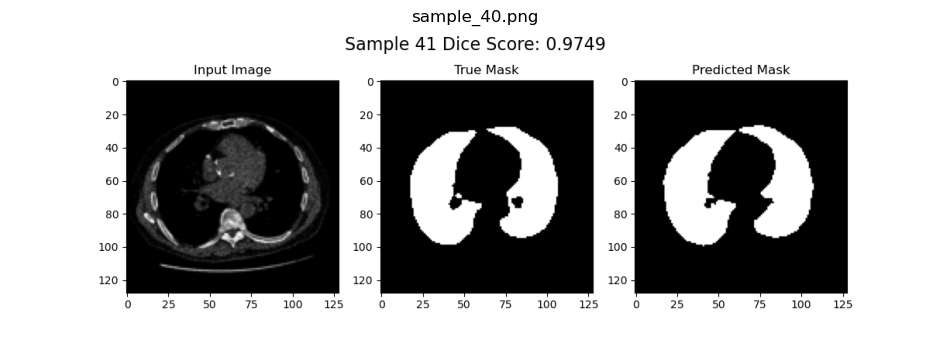

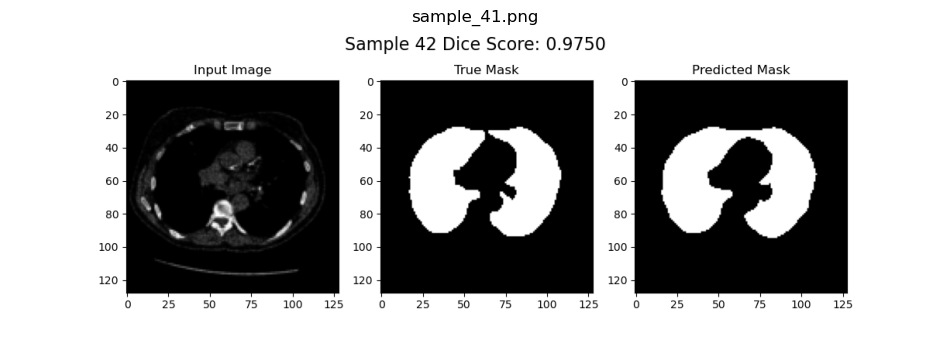

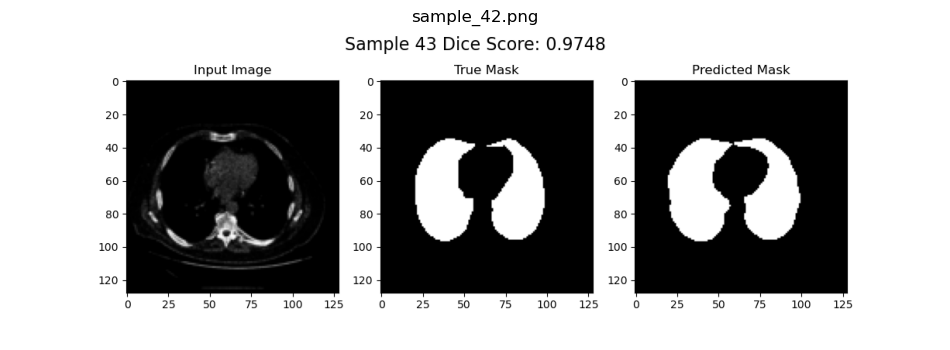

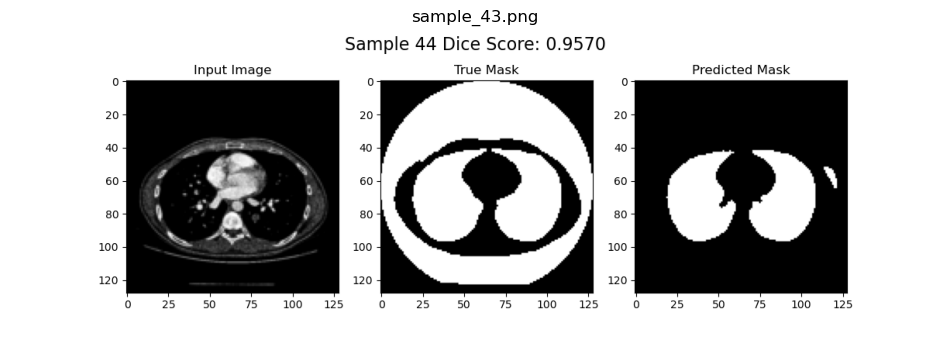

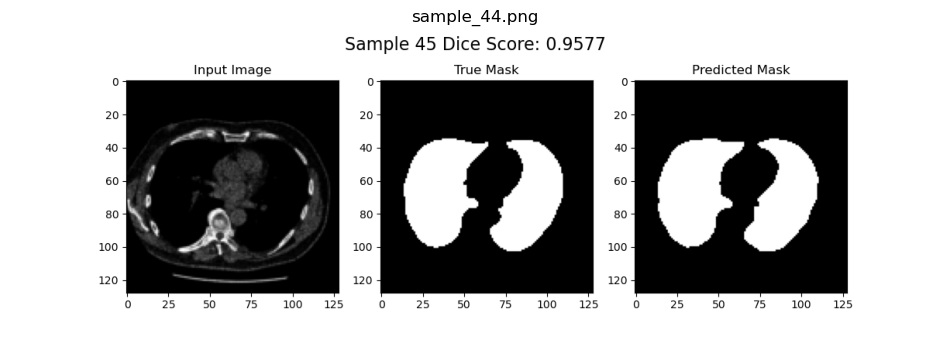

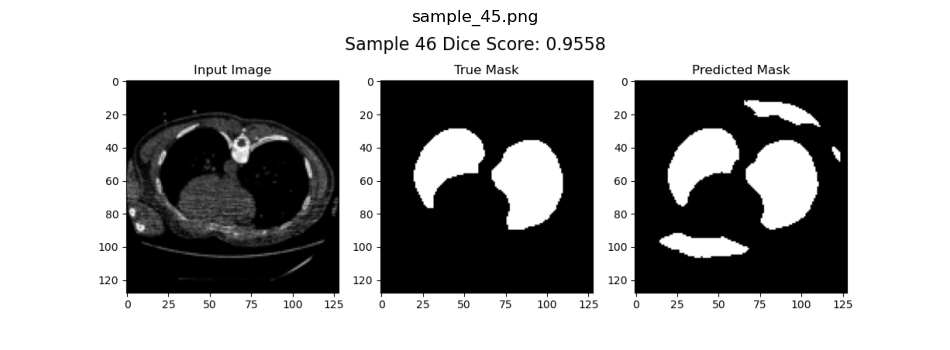

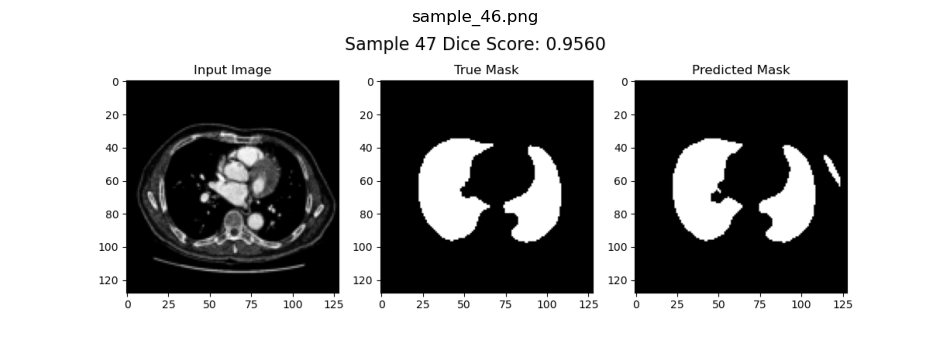

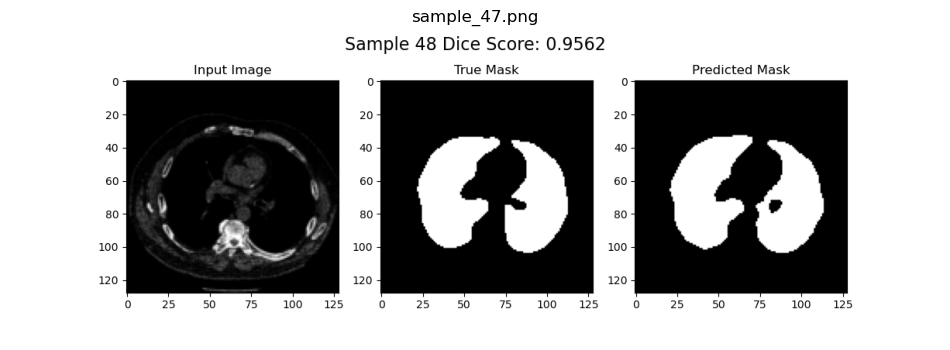

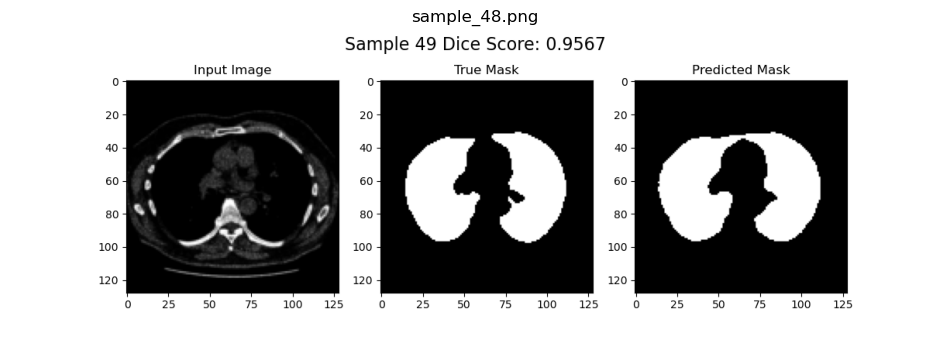

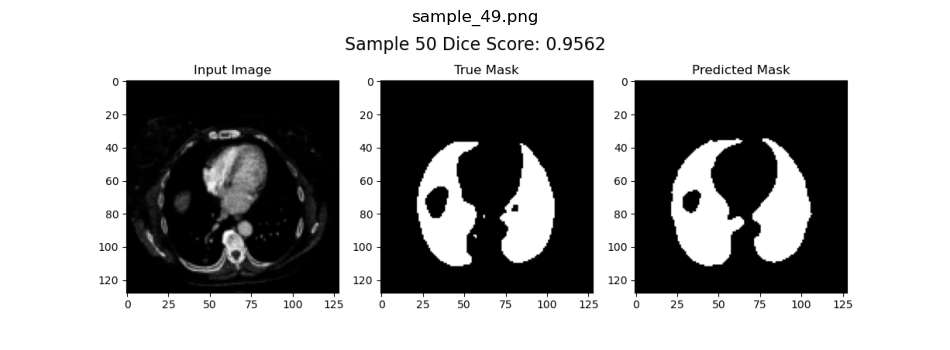

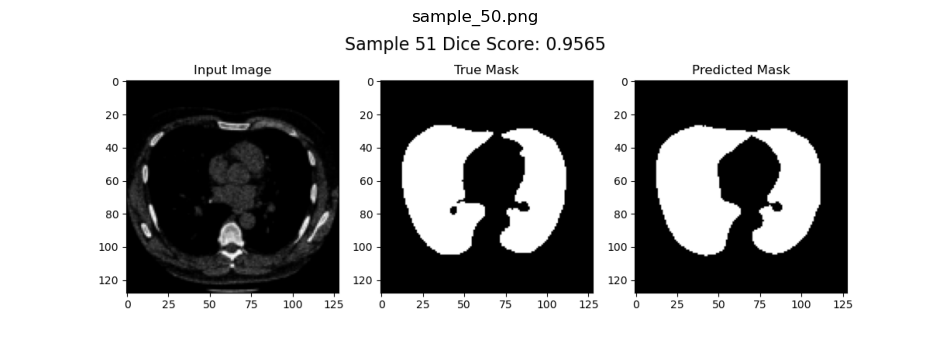

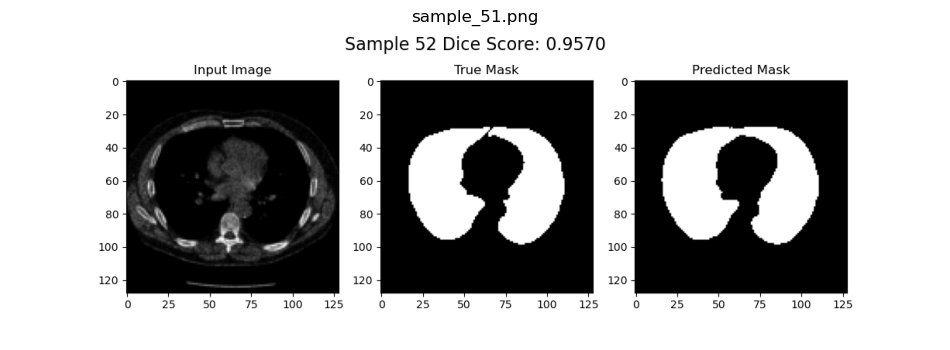

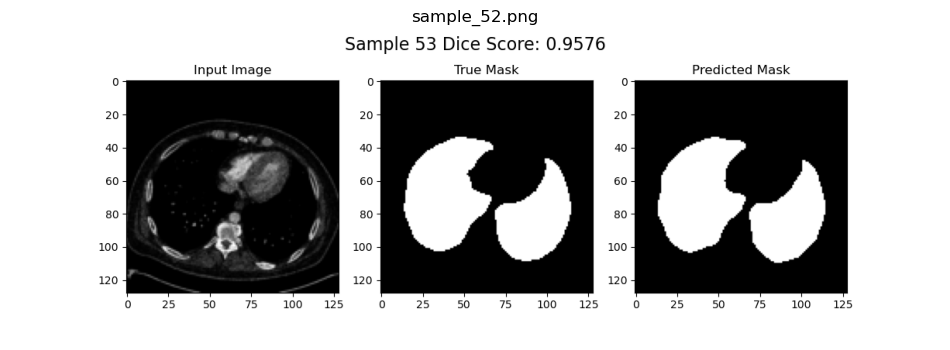

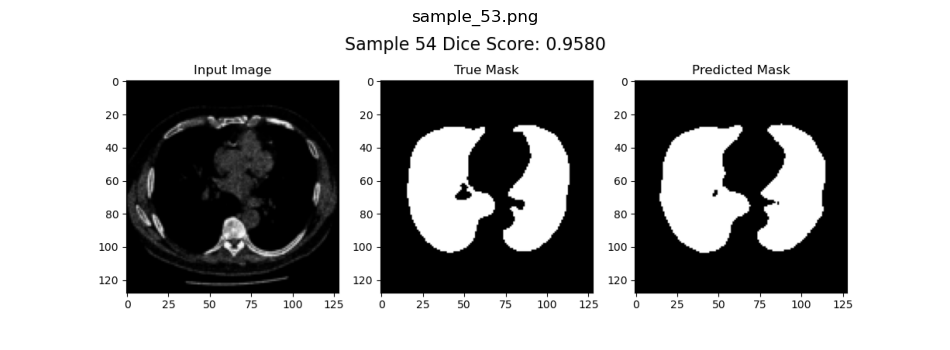

In [90]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

# Directory containing the images
image_folder = './predictions/'

# List all files in the directory
image_files = natsorted([f for f in os.listdir(image_folder) if f.endswith('.png')])

# Display each image one by one
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    img = Image.open(image_path)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(image_file)
    plt.show()